
# 🇰🇷 한국어 챗봇 (Transformer, SentencePiece) — End-to-End 노트북

**학습 목표**
- 한국어 전처리를 통해 학습 데이터셋을 구축한다.
- 공백·특수문자 처리, 토크나이징, 병렬 데이터(Q/A) 구축을 적절히 수행한다.
- 트랜스포머 모델을 구현하여 한국어 챗봇 모델을 학습한다.
- 구현한 모델이 안정적으로 수렴하도록 학습 루프/스케줄러/정규화를 적용한다.
- 한국어 입력 문장에 대해 한국어로 답변하는 함수를 구현한다.
- 입력 문맥에 맞는 한국어 답변을 리턴하도록 디코딩을 제공한다.

**평가 기준 체크리스트**
- [ ] 전처리: 공백·특수문자 정리, 반복문자 축약, 길이/중복 필터
- [ ] 토크나이징: SentencePiece(unigram) 학습 및 적용
- [ ] 병렬데이터 구축: (Q, A) 페어 분할(train/valid/test)
- [ ] 모델: nn.Transformer 기반 seq2seq, Label Smoothing, Gradient Clip
- [ ] 수렴: Noam warmup 스케줄러, 검증 Perplexity 모니터링(Plot 포함)
- [ ] 추론: Greedy & Top-k/Top-p 디코딩 함수 (한국어 입력 → 한국어 출력)


## 셀 0 — 필수 라이브러리 설치

In [ ]:

!pip install -q torch torchvision torchaudio sentencepiece pandas scikit-learn tqdm numpy


# Step1 기본 import & 설정

In [30]:
# =========================================================
# 한국어 챗봇 학습 파이프라인 (SentencePiece + Transformer)
# =========================================================
import os, re, math, time, unicodedata, random, glob
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import sentencepiece as spm

# --------- 0) 설정/시드 ----------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE, "| torch:", torch.__version__)

DEVICE: cuda | torch: 2.7.1+cu118


# Step 2: 데이터 전처리

In [33]:
# --------- 1) 데이터 전처리 ----------
DATA_CSV = "data/ChatbotData.csv"
assert os.path.exists(DATA_CSV), f"'{DATA_CSV}' 없음. 경로 확인."

def normalize_text(s: str) -> str:
    if not isinstance(s, str): return ""
    s = unicodedata.normalize("NFKC", s).strip()
    s = re.sub(r'ㅋ{2,}', 'ㅋㅋ', s); s = re.sub(r'ㅎ{2,}', 'ㅎㅎ', s)
    s = re.sub(r'!{2,}', '!!', s);  s = re.sub(r'\?{2,}', '??', s)
    s = re.sub(r'[\s\u200b]+', ' ', s)
    return s

df = pd.read_csv(DATA_CSV)[["Q","A"]].dropna().copy()
df["Q"] = df["Q"].apply(normalize_text)
df["A"] = df["A"].apply(normalize_text)
df = df[(df["Q"].str.len().between(2,128)) & (df["A"].str.len().between(2,128))]
df = df.drop_duplicates(["Q","A"]).reset_index(drop=True)

train_df, tmp_df = train_test_split(df, test_size=0.2, random_state=SEED, shuffle=True)
valid_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=SEED, shuffle=True)

with open("corpus.txt","w",encoding="utf-8") as f:
    for s in pd.concat([train_df["Q"], train_df["A"]], axis=0).tolist():
        if s: f.write(s+"\n")

train_df.to_csv("train_pairs.csv", index=False)
valid_df.to_csv("valid_pairs.csv", index=False)
test_df.to_csv("test_pairs.csv", index=False)
print(f"train={len(train_df)}, valid={len(valid_df)}, test={len(test_df)}")

train=9392, valid=1174, test=1174


# Step 3: SentencePiece 학습 (vocab_size 자동 조정)

In [34]:
# --------- 2) SentencePiece (PAD/UNK/BOS/EOS 고정) ----------
def train_spm(corpus="corpus.txt", prefix="spm_kor",
              try_sizes=(16000,12000,10000,8000,6000,4000),
              coverage=0.9995, user_syms=("<usr>","<sys>","<sep>")):
    last = None
    for vs in try_sizes:
        try:
            print(f"[SPM] vocab_size={vs}")
            spm.SentencePieceTrainer.train(
                input=corpus, model_prefix=prefix, vocab_size=vs, model_type="unigram",
                character_coverage=coverage, input_sentence_size=1_000_000, shuffle_input_sentence=True,
                user_defined_symbols=list(user_syms), pad_id=0, unk_id=1, bos_id=2, eos_id=3
            )
            return f"{prefix}.model", f"{prefix}.vocab"
        except Exception as e:
            print("  fail:", e); last = e
    raise RuntimeError(last)

SPM_MODEL, SPM_VOCAB = train_spm()
sp = spm.SentencePieceProcessor(model_file=SPM_MODEL)
VOCAB_SIZE = sum(1 for _ in open(SPM_VOCAB, encoding="utf-8"))
PAD_ID, UNK_ID, BOS_ID, EOS_ID = sp.pad_id(), sp.unk_id(), sp.bos_id(), sp.eos_id()
print("IDs:", dict(PAD=PAD_ID, UNK=UNK_ID, BOS=BOS_ID, EOS=EOS_ID), "| VOCAB:", VOCAB_SIZE)

[SPM] vocab_size=16000
  fail: Internal: src/trainer_interface.cc(664) [(trainer_spec_.vocab_size()) == (model_proto->pieces_size())] Vocabulary size too high (16000). Please set it to a value <= 8827.
[SPM] vocab_size=12000
  fail: Internal: src/trainer_interface.cc(664) [(trainer_spec_.vocab_size()) == (model_proto->pieces_size())] Vocabulary size too high (12000). Please set it to a value <= 8827.
[SPM] vocab_size=10000
  fail: Internal: src/trainer_interface.cc(664) [(trainer_spec_.vocab_size()) == (model_proto->pieces_size())] Vocabulary size too high (10000). Please set it to a value <= 8827.
[SPM] vocab_size=8000
IDs: {'PAD': 0, 'UNK': 1, 'BOS': 2, 'EOS': 3} | VOCAB: 8000


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: corpus.txt
  input_format: 
  model_prefix: spm_kor
  model_type: UNIGRAM
  vocab_size: 16000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 1000000
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <usr>
  user_defined_symbols: <sys>
  user_defined_symbols: <sep>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  e

# 데이터셋/콜레이트 (길이 일치 보장)

In [35]:
# --------- 3) Dataset / Collate (teacher forcing 정렬) ----------
class ChatDataset(Dataset):
    def __init__(self, csv_path, sp_model, max_len=128):
        self.df = pd.read_csv(csv_path)
        self.sp = spm.SentencePieceProcessor(model_file=sp_model)
        self.max_len = max_len
        self.pad_id, self.bos_id, self.eos_id = self.sp.pad_id(), self.sp.bos_id(), self.sp.eos_id()

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        q, a = self.df.iloc[i]["Q"], self.df.iloc[i]["A"]
        # 인코더 입력: "<usr> Q <sep> </s>"
        src = self.sp.encode(f"<usr> {q} <sep>", out_type=int)[:self.max_len-1] + [self.eos_id]
        # 타깃: y + EOS  /  디코더 입력: BOS + y[:-1]
        y   = self.sp.encode(a, out_type=int)[:self.max_len-1] + [self.eos_id]
        dec = [self.bos_id] + y[:-1]
        return torch.tensor(src), torch.tensor(dec), torch.tensor(y)

def collate_fn(batch, pad_id=0):
    srcs, decs, tgts = zip(*batch)
    def pad_to_len(seqs, L):
        out = torch.full((len(seqs), L), pad_id, dtype=torch.long)
        for i, x in enumerate(seqs): out[i,:min(L, x.size(0))] = x[:L]
        return out
    src_L = max(x.size(0) for x in srcs)
    tgt_L = max(x.size(0) for x in tgts)  # dec/tgt 동일 길이
    return pad_to_len(srcs, src_L), pad_to_len(decs, tgt_L), pad_to_len(tgts, tgt_L)

# Step4 — 모델 정의 (Transformer + 위치 인코딩, bool causal mask)

In [36]:
# --------- 4) 모델 ----------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=2048):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0)/d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:,0::2] = torch.sin(pos*div); pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer("pe", pe)
    def forward(self, x): return self.dropout(x + self.pe[:x.size(1)])

class Seq2SeqTransformer(nn.Module):
    def __init__(self, vocab, d_model=256, nhead=4, num_layers=3, dim_ff=1024, dropout=0.1, pad_id=0):
        super().__init__()
        self.pad_id = pad_id
        self.src_emb = nn.Embedding(vocab, d_model, padding_idx=pad_id)
        self.tgt_emb = nn.Embedding(vocab, d_model, padding_idx=pad_id)
        self.pos = PositionalEncoding(d_model, dropout)
        self.tf = nn.Transformer(d_model=d_model, nhead=nhead,
                                 num_encoder_layers=num_layers,
                                 num_decoder_layers=num_layers,
                                 dim_feedforward=dim_ff,
                                 dropout=dropout, batch_first=True)
        self.lm_head = nn.Linear(d_model, vocab, bias=False)
        self.lm_head.weight = self.tgt_emb.weight  # weight tying

    def _padmask(self, x): return (x == self.pad_id)
    def _causal(self, T, dev): return torch.triu(torch.ones((T,T), dtype=torch.bool, device=dev),1)

    def forward(self, src, dec_in):
        src_pm = self._padmask(src); tgt_pm = self._padmask(dec_in)
        tgt_mask = self._causal(dec_in.size(1), dec_in.device)
        src = self.pos(self.src_emb(src)); tgt = self.pos(self.tgt_emb(dec_in))
        out = self.tf(src, tgt, src_key_padding_mask=src_pm, tgt_key_padding_mask=tgt_pm, tgt_mask=tgt_mask)
        return self.lm_head(out)

# 학습 루프 (AMP/Noam/조기중단/학습곡선 플롯)

/tmp/ipykernel_928/2241826541.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


[Sanity] initial loss=84.973 vs log(V)≈8.99


Train 1:   0%|          | 0/147 [00:00<?, ?it/s]/tmp/ipykernel_928/2241826541.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Valid 1:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_928/2241826541.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Valid 1: 100%|██████████| 19/19 [00:00<00:00, 57.77it/s]


[1] train=24.663 | valid=14.928 | ppl=3040570.24
  -> saved


Valid 2: 100%|██████████| 19/19 [00:00<00:00, 61.05it/s]


[2] train=14.294 | valid=11.447 | ppl=93581.53
  -> saved


Valid 3: 100%|██████████| 19/19 [00:00<00:00, 60.75it/s]


[3] train=11.259 | valid=9.489 | ppl=13212.37
  -> saved


Valid 4: 100%|██████████| 19/19 [00:00<00:00, 56.59it/s]


[4] train=9.401 | valid=8.065 | ppl=3181.39
  -> saved


Valid 5: 100%|██████████| 19/19 [00:00<00:00, 61.46it/s]


[5] train=8.113 | valid=7.283 | ppl=1455.90
  -> saved


Valid 6: 100%|██████████| 19/19 [00:00<00:00, 59.77it/s]


[6] train=7.224 | valid=6.624 | ppl=752.99
  -> saved


Valid 7: 100%|██████████| 19/19 [00:00<00:00, 61.79it/s]


[7] train=6.556 | valid=6.153 | ppl=470.15
  -> saved


Valid 8: 100%|██████████| 19/19 [00:00<00:00, 60.55it/s]


[8] train=6.034 | valid=5.779 | ppl=323.29
  -> saved


Valid 9: 100%|██████████| 19/19 [00:00<00:00, 55.10it/s]


[9] train=5.606 | valid=5.430 | ppl=228.23
  -> saved


Valid 10: 100%|██████████| 19/19 [00:00<00:00, 58.14it/s]


[10] train=5.235 | valid=5.175 | ppl=176.86
  -> saved


Valid 11: 100%|██████████| 19/19 [00:00<00:00, 62.43it/s]


[11] train=4.913 | valid=4.953 | ppl=141.59
  -> saved


Valid 12: 100%|██████████| 19/19 [00:00<00:00, 61.49it/s]


[12] train=4.620 | valid=4.767 | ppl=117.61
  -> saved


Valid 13: 100%|██████████| 19/19 [00:00<00:00, 59.92it/s]


[13] train=4.363 | valid=4.652 | ppl=104.80
  -> saved


Valid 14: 100%|██████████| 19/19 [00:00<00:00, 61.62it/s]


[14] train=4.136 | valid=4.525 | ppl=92.31
  -> saved


Valid 15: 100%|██████████| 19/19 [00:00<00:00, 60.62it/s]


[15] train=3.927 | valid=4.513 | ppl=91.16
  -> saved


Valid 16: 100%|██████████| 19/19 [00:00<00:00, 62.18it/s]


[16] train=3.805 | valid=4.523 | ppl=92.11


Valid 17: 100%|██████████| 19/19 [00:00<00:00, 62.54it/s]


[17] train=3.674 | valid=4.539 | ppl=93.59


Valid 18: 100%|██████████| 19/19 [00:00<00:00, 60.39it/s]


[18] train=3.541 | valid=4.417 | ppl=82.88
  -> saved


Valid 19: 100%|██████████| 19/19 [00:00<00:00, 60.52it/s]


[19] train=3.417 | valid=4.315 | ppl=74.82
  -> saved


Valid 20: 100%|██████████| 19/19 [00:00<00:00, 60.64it/s]


[20] train=3.286 | valid=4.300 | ppl=73.67
  -> saved


Valid 21: 100%|██████████| 19/19 [00:00<00:00, 57.67it/s]


[21] train=3.167 | valid=4.380 | ppl=79.88


Valid 22: 100%|██████████| 19/19 [00:00<00:00, 62.10it/s]


[22] train=3.057 | valid=4.264 | ppl=71.10
  -> saved


Valid 23: 100%|██████████| 19/19 [00:00<00:00, 61.09it/s]


[23] train=2.944 | valid=4.420 | ppl=83.11


Valid 24: 100%|██████████| 19/19 [00:00<00:00, 48.89it/s]


[24] train=2.836 | valid=4.353 | ppl=77.74


Valid 25: 100%|██████████| 19/19 [00:00<00:00, 58.99it/s]

[25] train=2.714 | valid=4.440 | ppl=84.81
Early stopping.
Time: 2.5 min


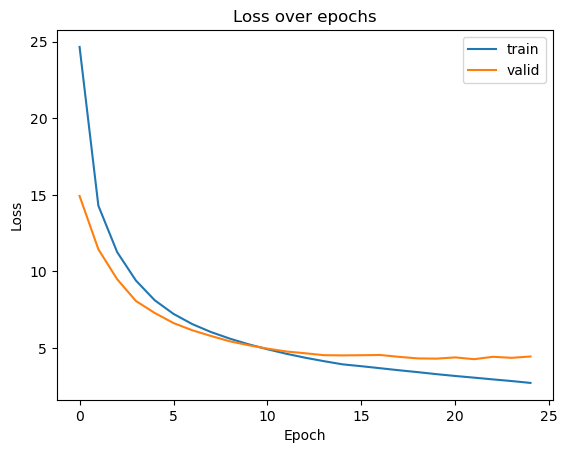

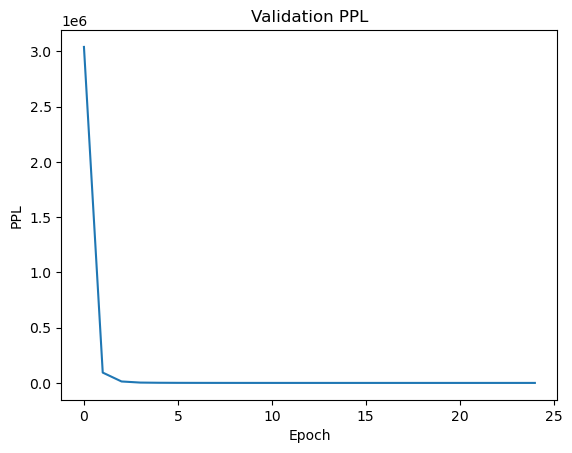

In [39]:
# --------- 5) 학습(고정 LR / AMP 선택) + sanity check ----------
train_ds = ChatDataset("train_pairs.csv", SPM_MODEL, 128)
valid_ds = ChatDataset("valid_pairs.csv", SPM_MODEL, 128)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True,  collate_fn=lambda b: collate_fn(b, PAD_ID))
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False, collate_fn=lambda b: collate_fn(b, PAD_ID))

model = Seq2SeqTransformer(VOCAB_SIZE, d_model=256, nhead=4, num_layers=3, dim_ff=1024, pad_id=PAD_ID).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID, label_smoothing=0.0)  # 먼저 0.0로 안정화
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, betas=(0.9,0.98), weight_decay=0.01)

USE_AMP = (DEVICE=="cuda")
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

# ---- Sanity check: 초기 손실이 log(V) 근처(≈8~10)인지 검사 ----
model.eval()
with torch.no_grad():
    src, dec, tgt = next(iter(train_dl))
    src, dec, tgt = src.to(DEVICE), dec.to(DEVICE), tgt.to(DEVICE)
    logits = model(src, dec)
    init_loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), tgt.reshape(-1), ignore_index=PAD_ID)
    print(f"[Sanity] initial loss={init_loss.item():.3f} vs log(V)≈{math.log(VOCAB_SIZE):.2f}")

# ---- Train loop ----
EPOCHS, GRAD_CLIP, PATIENCE = 25, 1.0, 3
best = float("inf"); noimp = 0
hist = {"train":[], "valid":[], "ppl":[]}
t0 = time.time()

for ep in range(1, EPOCHS+1):
    model.train(); tot=cnt=0
    for src, dec, tgt in tqdm(train_dl, desc=f"Train {ep}"):
        src, dec, tgt = src.to(DEVICE), dec.to(DEVICE), tgt.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits = model(src, dec)                           # (B,T,V)
            loss = criterion(logits.reshape(-1, logits.size(-1)), tgt.reshape(-1))
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        scaler.step(optimizer); scaler.update()
        tot += loss.item(); cnt += 1
    tr = tot/max(1,cnt); hist["train"].append(tr)

    model.eval(); vtot=vcnt=0
    with torch.no_grad():
        for src, dec, tgt in tqdm(valid_dl, desc=f"Valid {ep}"):
            src, dec, tgt = src.to(DEVICE), dec.to(DEVICE), tgt.to(DEVICE)
            with torch.cuda.amp.autocast(enabled=USE_AMP):
                logits = model(src, dec)
                vl = criterion(logits.reshape(-1, logits.size(-1)), tgt.reshape(-1))
            vtot += vl.item(); vcnt += 1
    va = vtot/max(1,vcnt); ppl = math.exp(va)
    hist["valid"].append(va); hist["ppl"].append(ppl)
    print(f"[{ep}] train={tr:.3f} | valid={va:.3f} | ppl={ppl:.2f}")

    if va < best:
        best, noimp = va, 0
        torch.save(model.state_dict(), "tf_chat_best.pt")
        print("  -> saved")
    else:
        noimp += 1
        if noimp >= PATIENCE:
            print("Early stopping."); break

print(f"Time: {(time.time()-t0)/60:.1f} min")

plt.figure(); plt.plot(hist["train"],label="train"); plt.plot(hist["valid"],label="valid")
plt.title("Loss over epochs"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()
plt.figure(); plt.plot(hist["ppl"]); plt.title("Validation PPL"); plt.xlabel("Epoch"); plt.ylabel("PPL"); plt.show()

# Step 5: 추론 함수 (Greedy / Top-k·Top-p, 문맥 옵션)

In [40]:
# --------- 6) 추론 (특수토큰 금지/반복 억제) ----------
FORBIDDEN = [sp.piece_to_id(p) for p in ("<usr>","<sys>","<sep>") if sp.piece_to_id(p) >= 0]

def _enc_src(q, max_len=128):
    ids = sp.encode(f"<usr> {q} <sep>", out_type=int)[:max_len-1] + [EOS_ID]
    return torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(DEVICE)

def greedy(q, max_len=48, rep_penalty=1.2):
    model.eval(); src=_enc_src(q); dec=torch.tensor([[BOS_ID]],dtype=torch.long,device=DEVICE)
    with torch.no_grad():
        for _ in range(max_len):
            logits = model(src, dec)[:,-1,:]
            logits[:, BOS_ID] = -1e9
            if FORBIDDEN: logits[:, FORBIDDEN] = -1e9
            for t in set(dec[0].tolist()): logits[0,t] /= rep_penalty
            nid = int(logits.argmax(-1)); dec=torch.cat([dec, torch.tensor([[nid]],device=DEVICE)],1)
            if nid==EOS_ID: break
    out=dec[0].tolist()[1:];  out=out[:out.index(EOS_ID)] if EOS_ID in out else out
    return sp.decode(out)

def preview_table(csv="test_pairs.csv", n=5, seed=9722):
    samp = pd.read_csv(csv).sample(n, random_state=seed).reset_index(drop=True)
    preds = [greedy(q) for q in samp["Q"].tolist()]
    return pd.DataFrame({"Q":samp["Q"], "A (model)":preds, "A (gold)":samp["A"]})

print(preview_table("test_pairs.csv", 20, 9722))

                                     Q         A (model)  \
0                              썸인지 헷갈려          잘 찾아보세요.   
1                         주말에 뭐 하고 놀까?          잘하고 있어요.   
2                      긴 시간이 걸렸지만 괜찮아.    마음이 좀 더 벗어나세요.   
3                    장난인지 진심인지 구분이 안돼.          잘하고 있어요.   
4                     갑자기 나쁜 생각이 막 들더라      생각보다 많이 하세요.   
5                              덕질 하는 중     좋은 사람 만날 거예요.   
6                           이대로 이별이겠죠?          잘하고 있어요.   
7                오늘 짝녀 만나기로 했는데 옷이 없네.     좋은 사람 만날 거예요.   
8        남자들 직장 내에서 좋아하는 여자 있으면 어떻게 해?          제가 있잖아요.   
9                            아침부터 답답하네          일찍 주무세요.   
10                            지옥같은 주말.     사랑의 연락하지 마세요.   
11              짝남한테 크리스마스 선물할건데 추천 좀.          잘 찾아보세요.   
12                      저 사람이 왜 자꾸 볼까?  그 사람을 많이 사랑했나봐요.   
13                    평생하고 싶은거 찾아야 할텐데          잘 찾아보세요.   
14  좋아하는 여자애한테 어떻게 하면 좋은 인상을 남길 수 있을까?          잘 찾아보세요.   
15                           또 하루가 간다.  